In [1]:
import hydra
import torch
import pickle
import glob
from tqdm import tqdm
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from src.utils import get_cfg_from_from_ckpt_path
import re

In [2]:
plt.style.use('ggplot')

In [3]:
def load_model(model_ckpt_path: str,
               device: str):

    cfg = get_cfg_from_from_ckpt_path(model_ckpt_path, pprint = False)
    
    lit_mod = hydra.utils.call(cfg.model)

    lit_mod.load_state_dict(torch.load(model_ckpt_path)["state_dict"])


    lit_mod = lit_mod.to(device) # Move model to gpu for faster inference
    lit_mod = lit_mod.eval() # Model in eval mode
    for param in lit_mod.parameters():
        param.requires_grad = False  # Ensure no gradients are calculated for this model

    return lit_mod

In [4]:
def explicit_ecs(ssp: torch.tensor,
                 depth_tens: torch.tensor,
                 tau = 100):
    ssp = ssp.unsqueeze(1).nan_to_num()          
    kernel = torch.tensor([-1.0, 1.0]).float().view(1,1,2,1,1).to(ssp.device)
    derivative = F.conv3d(ssp, kernel, padding=(0,0,0))

    #sign = DF.differentiable_sign(derivative)

    sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()
    #print("After torch.sign (sign):", sign.requires_grad, sign.grad_fn)


    sign_diff = F.conv3d(sign, kernel, padding=(1,0,0))
    sign_change = F.tanh(10*F.relu(-sign_diff))

    for pattern in ([1, 0, 1], [1, -1, 0, 0]):  
        n = len(pattern)
        kernel_matrix = torch.eye(n)
        element_match = 0
        for i in range(n):
            kernel_element = kernel_matrix[i,:].view(1,1,n,1,1).to(ssp.device)
            element_match = element_match + (F.conv3d(sign, kernel_element, padding=(0,0,0)) - pattern[i])**2

        pattern_recognition = F.pad( element_match, (0, 0, 0, 0, 1, (sign_change.shape[2]- element_match.shape[2]) - 1),value=1.)    
        mask_discontinuity = 1 - F.relu(pattern_recognition+1) * F.relu(1-pattern_recognition)

        sign_change = sign_change * mask_discontinuity


    mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

    depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1,1,1).to(ssp.device).type(sign_change.dtype)
    depth_array_tens[0,0,0,0] = 0.  ##TODO the true first z value is equal to 48cm. It may have to be considered that way
    ecs_pred = (sign_change * mask ).squeeze(dim=1)
    ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values 
    return ecs_pred

In [5]:
load_data = True

In [6]:
model_ckpt_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_pool_2D/pred_1_var_0_gradient_0_ecs_0/latent_dim_107_pooling_1_None_dropout_0_patience_5/None/2024-07-15_18-24/checkpoints/val_loss=0.00-epoch=30.ckpt"


In [7]:
gpu = 1
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [8]:
cfg = get_cfg_from_from_ckpt_path(model_ckpt_path, pprint = True)

```yaml

datamodule:
  _target_: src.data.BaseDatamodule
  dl_kw: {batch_size: '${model_config.batch_size.${dimensions}}', num_workers: 4}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssf_ecs_da, ecs_da_path: '${paths.variables}',
    ssf_da_path: '${paths.sound}'}
  norm_stats: {method: mean_std_along_depth, params: '${normalization.${datamodule.norm_stats.method}}'}
dimensions: 2D
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dm: '${datamodule}', lit_mod: '${model}', trainer: '${trainer}'}
model:
  _target_: src.autoencoder_V2.AutoEncoder
  depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
  loss_weight: {ecs_weight: 0, gradient_weight: 0, prediction_weight: 1, variation_weight: 0}
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}_${dimensions}
  opt_fn: {T_max: '${trainer.max_epochs}', _partial_: true, _target_: src.ecs_classification.ECS_classification.cosanneal_lr_adamw,
    lr: 0.01, weight_decay: 0.001}
model_architecture: AE_CNN_pool
model_config:
  accumulate_grad_batches: {2D: 1, 3D: 4}
  batch_size: {2D: 4, 3D: 1}
  model_hparams:
    AE_CNN_2D:
      act_fn_str: None
      base_channels: 107
      batch_norm: false
      dropout_proba: 0
      dtype_str: float32
      latent_dim: 3
      linear_layer: true
      num_layers: 5
      spatial_dim: [107, 240, 240]
    AE_CNN_3D:
      act_fn_str: None
      base_channels: 1
      batch_norm: false
      dropout_proba: 0
      dtype_str: float32
      latent_dim: 3
      linear_layer: true
      num_layers: 5
      spatial_dim: [107, 240, 240]
    AE_CNN_pool_2D:
      act_fn_str: None
      dropout_proba: 0
      dtype_str: float32
      final_act_fn_str: None
      init_params:
        params: {_target_: src.utils.get_convo_init_weight_bias, init_params_pickle_path: "/homes/o23gauvr/Documents/th\xE8\
            se/code/FASCINATION/pickle/pca_mean_and_components.pkl"}
        use: true
      input_channels: 107
      latent_dim: 107
      num_layers: 1
      pooling_str: None
    ECS_explicit_pred_3D:
      depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
  save_dir:
    AE_CNN: {version: 'latent_dim_${model.model_hparams.latent_dim}_num_layers_${model.model_hparams.num_layers}_linear_${model.model_hparams.linear_layer}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}/${model.model_hparams.act_fn_str}/${now:%Y-%m-%d_%H-%M}'}
    AE_CNN_pool: {version: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}/${model.model_hparams.act_fn_str}/${now:%Y-%m-%d_%H-%M}'}
normalization:
  mean_std: {mean: 1513.8417292146794, std: 14.949060449731395}
  mean_std_along_depth: {mean: null, std: null}
  min_max: {x_max: 1545.8698054910844, x_min: 1459.0439165829073}
paths: {sound: /DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc, variables: /DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_at_0_regrid_0_1000m.nc}
patience: 5
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: ${model_config.accumulate_grad_batches.${dimensions}}
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, check_on_train_epoch_end: true,
    min_delta: 0.0, monitor: val_loss, patience: '${patience}', verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, log_graph: false,
    name: '${model.model_name}/pred_${model.loss_weight.prediction_weight}_var_${model.loss_weight.variation_weight}_gradient_${model.loss_weight.gradient_weight}_ecs_${model.loss_weight.ecs_weight}',
    save_dir: "/homes/o23gauvr/Documents/th\xE8se/code/FASCINATION/outputs/AE_V2/",
    version: '${model_config.save_dir.${model_architecture}.version}'}
  max_epochs: 1000
  min_epochs: 0


```

In [9]:
dm = hydra.utils.call(cfg.datamodule) # will instantiate src.data.BaseDataModule with parameters specified in config
dm.setup(stage="fit") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api
dm.setup(stage="test") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api


In [10]:
depth_array = dm.train_dataloader().dataset.input.z.data

In [11]:
dm.train_dataloader().dataset.input.min()

<xarray.DataArray 'celerity' ()>
array(-6.)

In [13]:
train_ssp_ds = dm.train_dataloader().dataset.input
train_ssp_ds_drop_na = train_ssp_ds.dropna(dim='lat')
#train_ssp_ds_drop_na = train_ssp_ds.fillna(0)
train_ssp_arr = train_ssp_ds_drop_na.data
train_ssp_tens = torch.tensor(train_ssp_arr).float().to(device)
input_train_shape = train_ssp_arr.shape

test_ssp_ds = dm.test_dataloader().dataset.input
test_ssp_ds_drop_na = test_ssp_ds.dropna(dim='lat')
#test_ssp_ds_drop_na = test_ssp_ds.fillna(0)
test_ssp_arr = test_ssp_ds_drop_na.data
test_ssp_tens = torch.tensor(test_ssp_arr).float().to(device)
input_test_shape = test_ssp_arr.shape

ValueError: Dimension 'lat' not found in data dimensions ('z', 'merged_dim')

In [ ]:
print(train_ssp_arr.shape)
print(train_ssp_arr.min())
print(train_ssp_arr.max())

(256, 107, 240, 240)
-6.0
3.433906122590165


In [ ]:
coords = test_ssp_ds_drop_na.coords

In [ ]:
lit_model = load_model(model_ckpt_path, device)
ssp_pred = lit_model(test_ssp_tens)

In [ ]:
n_components = 107

In [ ]:
pca = PCA(n_components = n_components, svd_solver = 'auto')
X_train = train_ssp_arr.transpose(0,2,3,1).reshape(-1,107)
pca.fit(X_train)
X_train_hat =  pca.transform(X_train)
X_test = test_ssp_arr.transpose(0,2,3,1).reshape(-1,input_test_shape[1])
X_test_hat = pca.transform(X_test)
output_test_decoded_pca =  pca.inverse_transform(X_test_hat).reshape(input_test_shape[0],input_test_shape[2],input_test_shape[3],-1).transpose(0,3,1,2)

In [ ]:
ecs_truth = explicit_ecs(torch.tensor(test_ssp_arr).float(),torch.tensor(depth_array).float())
ecs_pred_pca = explicit_ecs(torch.tensor(output_test_decoded_pca).float(),torch.tensor(depth_array).float())
ecs_pred_ae = explicit_ecs(ssp_pred.float(),torch.tensor(depth_array).float())

In [ ]:
filters = torch.tensor(pca.components_).unsqueeze(-1)
filters.shape

torch.Size([107, 107, 1])

In [ ]:
X_train_tens = torch.tensor(X_train - pca.mean_).unsqueeze(-1) 
X_train_tens.shape

torch.Size([14745600, 107, 1])

In [ ]:
X_train_hat_convo = F.conv1d(X_train_tens,filters).squeeze(-1)
X_train_hat_convo.shape

torch.Size([14745600, 107])

Text(0.5, 0.98, '$\\hat{X}_{0}$')

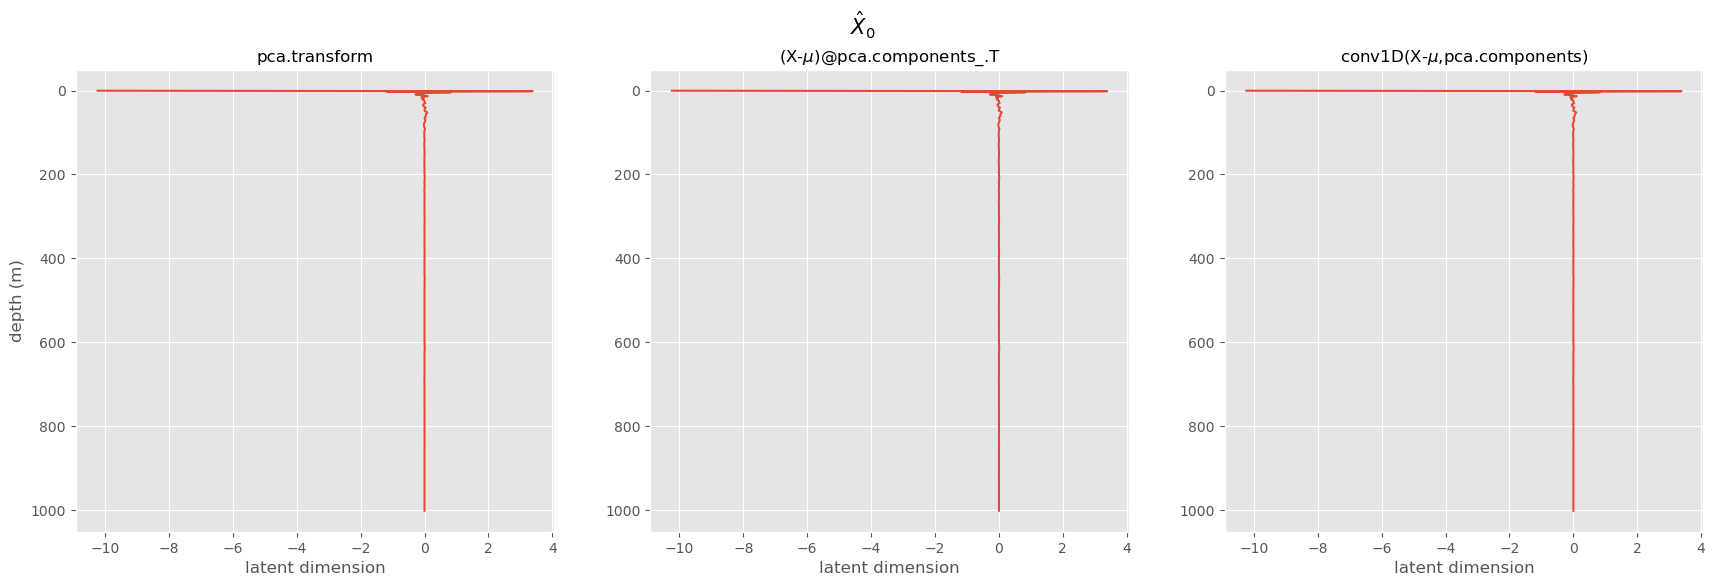

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(21,6))

axs[0].plot(X_train_hat[0,:], depth_array)
axs[1].plot(np.matmul(X_train-pca.mean_,pca.components_.T)[0,:] , depth_array)
axs[2].plot(X_train_hat_convo[0,:] , depth_array)

axs[0].set_title('pca.transform', fontsize = 12)
axs[1].set_title(r'(X-$\mu$)@pca.components_.T', fontsize = 12)
axs[2].set_title(r'conv1D(X-$\mu$,pca.components)', fontsize = 12)

axs[0].set_ylabel("depth (m)")

for ax in axs[:]:
    ax.invert_yaxis() 
    ax.set_xlabel("latent dimension")
    
fig.suptitle(r'$\hat{X}_{0}$',fontsize = 15, y=0.98)

Text(0.5, 0.95, '$X_{reconstructed,0}$')

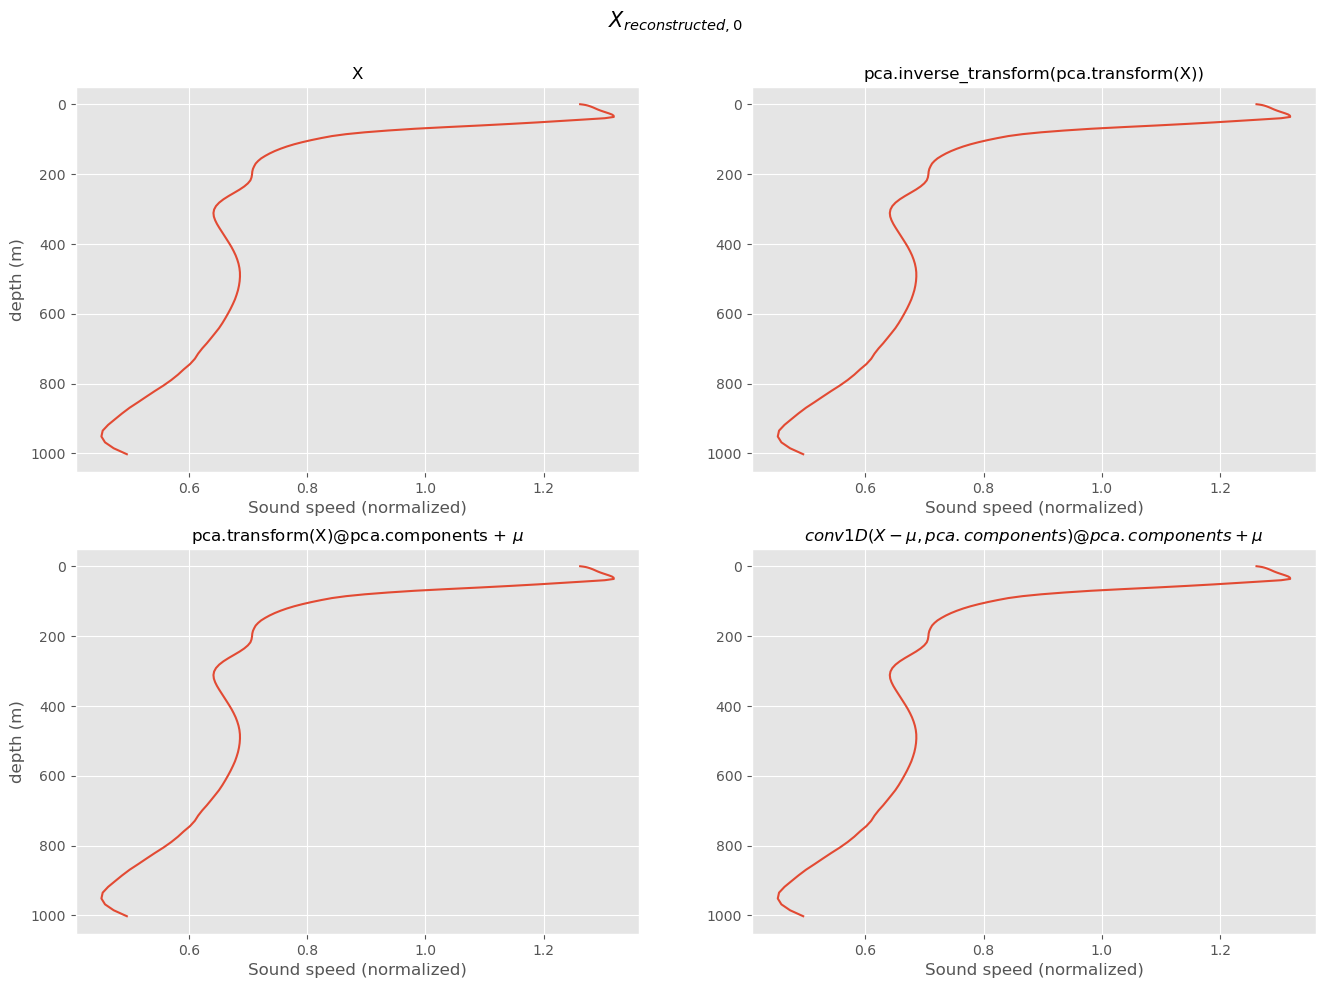

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(16,11))

axs[0,0].plot(X_train[0,:], depth_array)
axs[0,1].plot(pca.inverse_transform(pca.transform(X_train))[0,:], depth_array)
axs[1,0].plot(np.matmul(X_train_hat,pca.components_)[0,:] + pca.mean_, depth_array)
axs[1,1].plot(np.matmul(X_train_hat_convo.detach().numpy(),pca.components_)[0,:] + pca.mean_, depth_array)

axs[0,0].set_ylabel("depth (m)")
axs[1,0].set_ylabel("depth (m)")


axs[0,0].set_title('X', fontsize = 12)
axs[0,1].set_title('pca.inverse_transform(pca.transform(X))', fontsize = 12)
axs[1,0].set_title(r'pca.transform(X-$\mu$)@pca.components + $\mu$', fontsize = 12)
axs[1,1].set_title(r'$conv1D(X-\mu,pca.components)@pca.components + \mu$', fontsize = 12)


for ax in axs.ravel():

    ax.invert_yaxis() 
    ax.set_xlabel("Sound speed (normalized)")
    
fig.suptitle(r'$X_{reconstructed,0}$',fontsize = 15, y=0.95)

In [ ]:
n_features = 9

In [ ]:
conv2D = nn.Conv2d(in_channels = n_features, out_channels = n_components, kernel_size = 1, dtype = train_ssp_tens.dtype, device = train_ssp_tens.device)

In [ ]:
nn.init.constant_(conv2D.bias, 0) #torch.nn.Parameter(torch.empty(0))
conv2D.bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:1',
       requires_grad=True)

In [ ]:
conv2D.weight = torch.nn.parameter.Parameter(torch.tensor(pca.components_, dtype=conv2D.weight.dtype, device = train_ssp_tens.device).unsqueeze(-1).unsqueeze(-1))

In [ ]:
X_train_hat_convo_2D = conv2D(train_ssp_tens - torch.tensor(pca.mean_.reshape(1,-1,1,1), dtype = train_ssp_tens.dtype, device = train_ssp_tens.device))

In [ ]:
X_train_hat_2D = X_train_hat.reshape(input_train_shape[0],input_train_shape[2],input_train_shape[3],-1).transpose(0,3,1,2)
X_train_hat_2D.shape

(256, 107, 240, 240)

In [ ]:
conv2D.bias = torch.nn.parameter.Parameter(torch.tensor(-pca.mean_, dtype=conv2D.weight.dtype, device = train_ssp_tens.device))
conv2D.bias

Parameter containing:
tensor([0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143,
        0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0277, 0.0285,
        0.0361, 0.0423, 0.0514, 0.0603, 0.0697, 0.0754, 0.0855, 0.0982, 0.1072,
        0.1182, 0.1370, 0.1669, 0.1848, 0.2019, 0.2174, 0.2296, 0.2397, 0.2514,
        0.2605, 0.2681, 0.2794, 0.2862, 0.2932, 0.2956, 0.3024, 0.3057, 0.3078,
        0.3124, 0.3153, 0.3200, 0.3216, 0.3221, 0.3229, 0.3237, 0.3246, 0.3251,
        0.3259, 0.3267, 0.3275, 0.3282, 0.3288, 0.3296, 0.3300, 0.3303, 0.3313,
        0.3322, 0.3327, 0.3330, 0.3338, 0.3338, 0.3340, 0.3342, 0.3352, 0.3354,
        0.3359, 0.3363, 0.3366, 0.3368, 0.3377, 0.3379, 0.3388, 0.3390, 0.3391,
        0.3395, 0.3399, 0.3404, 0.3413, 0.3418, 0.3423, 0.3429, 0.3434, 0.3439,
        0.3448, 0.3450, 0.3460, 0.3461, 0.3467, 0.3483, 0.3489, 0.3498, 0.3506,
        0.3511, 0.3521, 0.3527, 0.3537, 0.3555, 0.3566, 0.3577, 0.3599],
       device='cuda:1', r

In [ ]:
X_train_hat_convo_2D_mean_in_bias = conv2D(train_ssp_tens)

Text(0.5, 0.98, '$\\hat{X}_{0}$')

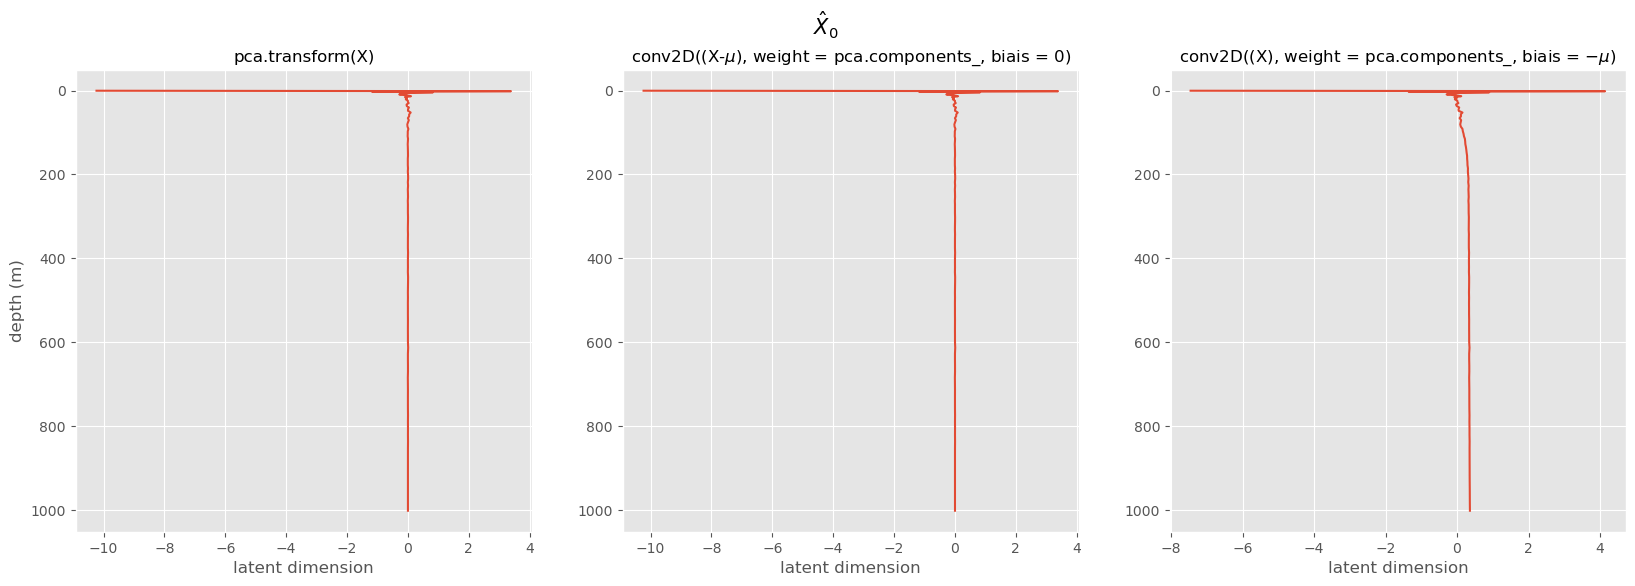

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(20,6))

axs[0].plot(X_train_hat_2D[0,:,0,0], depth_array)
axs[1].plot(X_train_hat_convo_2D.detach().cpu()[0,:,0,0] , depth_array) 
axs[2].plot(X_train_hat_convo_2D_mean_in_bias.detach().cpu()[0,:,0,0] , depth_array) 

axs[0].set_title('pca.transform(X)', fontsize = 12)
axs[1].set_title(r'conv2D((X-$\mu$), weight = pca.components_, biais = 0)', fontsize = 12)
axs[2].set_title(r'conv2D((X), weight = pca.components_, biais = $-\mu$)', fontsize = 12)


axs[0].set_ylabel("depth (m)")

for ax in axs[:]:
    ax.invert_yaxis() 
    ax.set_xlabel("latent dimension")
    
fig.suptitle(r'$\hat{X}_{0}$',fontsize = 15, y=0.98)

In [ ]:
convtrans2D = nn.ConvTranspose2d(in_channels = n_features, out_channels = n_components, kernel_size = 1, dtype = train_ssp_tens.dtype, device = train_ssp_tens.device)


In [ ]:
nn.init.constant_(convtrans2D.bias, 0) #torch.nn.Parameter(torch.empty(0))
convtrans2D.bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:1',
       requires_grad=True)

In [ ]:
convtrans2D.weight = torch.nn.parameter.Parameter(torch.tensor(pca.components_, dtype=conv2D.weight.dtype, device = train_ssp_tens.device).unsqueeze(-1).unsqueeze(-1))
convtrans2D.weight 

Parameter containing:
tensor([[[[-5.5075e-02]],

         [[-5.5195e-02]],

         [[-5.5286e-02]],

         ...,

         [[-1.0798e-01]],

         [[-1.0791e-01]],

         [[-1.0784e-01]]],


        [[[ 1.5772e-01]],

         [[ 1.5757e-01]],

         [[ 1.5745e-01]],

         ...,

         [[-9.5843e-02]],

         [[-9.6103e-02]],

         [[-9.6274e-02]]],


        [[[-1.1965e-01]],

         [[-1.1837e-01]],

         [[-1.1731e-01]],

         ...,

         [[-1.5483e-01]],

         [[-1.5715e-01]],

         [[-1.5911e-01]]],


        ...,


        [[[-9.4593e-04]],

         [[ 3.4944e-03]],

         [[-1.1034e-02]],

         ...,

         [[ 2.6275e-06]],

         [[ 6.8091e-07]],

         [[-8.9930e-07]]],


        [[[ 4.0873e-03]],

         [[-3.6346e-02]],

         [[ 1.6002e-01]],

         ...,

         [[-2.1868e-06]],

         [[ 1.9727e-07]],

         [[ 5.5941e-07]]],


        [[[ 5.0332e-04]],

         [[-3.3310e-03]],

         [[ 1.

In [ ]:
train_ssp_pred = convtrans2D(X_train_hat_convo_2D).detach().cpu().numpy() + pca.mean_.reshape(1,-1,1,1)


Text(0.5, 0.98, '$\\hat{X}_{0}$')

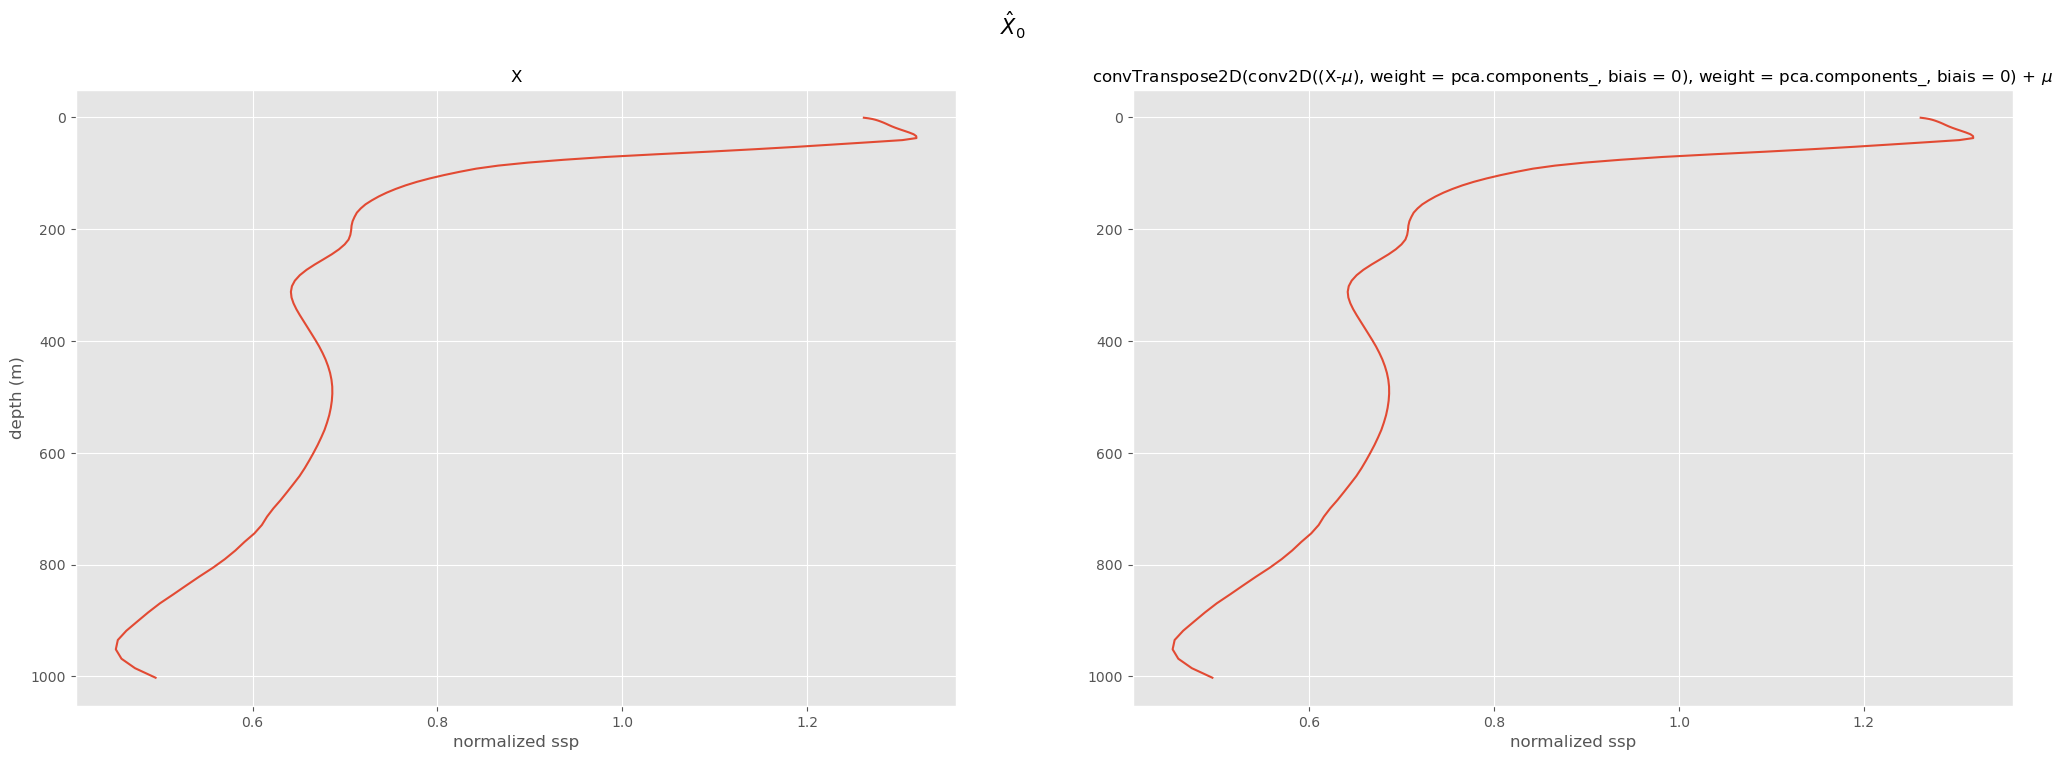

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(25,8))

axs[0].plot(train_ssp_tens[0,:,0,0].detach().cpu(), depth_array)
axs[1].plot(train_ssp_pred[0,:,0,0] , depth_array) 



axs[0].set_title('X', fontsize = 12)
axs[1].set_title(r'convTranspose2D(conv2D((X-$\mu$), weight = pca.components_, biais = 0), weight = pca.components_, biais = 0) + $\mu$', fontsize = 12)
#axs[2].set_title(r'conv2D((X), weight = pca.components_, biais = $-\mu$)', fontsize = 12)

#plt.subplots_adjust(hspace=10)
axs[0].set_ylabel("depth (m)")

for ax in axs[:]:
    ax.invert_yaxis() 
    ax.set_xlabel("normalized ssp")
    
fig.suptitle(r'$\hat{X}_{0}$',fontsize = 15, y=0.98)

## save pca components

In [ ]:
pca_train_components_dict = {"bias": pca.mean_}

for n_components in tqdm(range(107,108)):
    print(n_components)
    pca = PCA(n_components = n_components, svd_solver = 'auto')
    pca.fit(X_train)
    pca_train_components_dict["weight"] = pca.components_
    
    

  0%|          | 0/1 [00:00<?, ?it/s]

107


100%|██████████| 1/1 [02:57<00:00, 177.85s/it]


In [ ]:
pca_train_components_dict

{'weight': array([[-5.50750823e-02, -5.51953731e-02, -5.52859009e-02, ...,
         -1.07979560e-01, -1.07912058e-01, -1.07840716e-01],
        [ 1.57723543e-01,  1.57569142e-01,  1.57448508e-01, ...,
         -9.58429275e-02, -9.61034717e-02, -9.62738885e-02],
        [-1.19654227e-01, -1.18371848e-01, -1.17305141e-01, ...,
         -1.54825492e-01, -1.57145316e-01, -1.59114024e-01],
        ...,
        [-9.45933346e-04,  3.49437833e-03, -1.10338512e-02, ...,
          2.62750389e-06,  6.80910830e-07, -8.99301190e-07],
        [ 4.08733773e-03, -3.63459179e-02,  1.60017185e-01, ...,
         -2.18677707e-06,  1.97267683e-07,  5.59411952e-07],
        [ 5.03320367e-04, -3.33095198e-03,  1.46273294e-02, ...,
         -4.67369972e-07,  4.06790088e-07,  4.12370950e-07]]),
 'bias': array([-0.01427083, -0.01427083, -0.01427083, -0.01427083, -0.01427083,
        -0.01427083, -0.01427083, -0.01427083, -0.01427083, -0.01427083,
        -0.01427083, -0.01427083, -0.01427083, -0.01427083, -0.01

In [ ]:
import pickle

with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_mean_and_components.pkl", "wb") as file:
    pickle.dump(pca_train_components_dict, file)   

In [ ]:
with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_mean_and_components.pkl", "rb") as file:
    dico = pickle.load(file)   

In [ ]:
dico

{'weight': array([[-5.50750823e-02, -5.51953731e-02, -5.52859009e-02, ...,
         -1.07979560e-01, -1.07912058e-01, -1.07840716e-01],
        [ 1.57723543e-01,  1.57569142e-01,  1.57448508e-01, ...,
         -9.58429275e-02, -9.61034717e-02, -9.62738885e-02],
        [-1.19654227e-01, -1.18371848e-01, -1.17305141e-01, ...,
         -1.54825492e-01, -1.57145316e-01, -1.59114024e-01],
        ...,
        [-9.45933346e-04,  3.49437833e-03, -1.10338512e-02, ...,
          2.62750389e-06,  6.80910830e-07, -8.99301190e-07],
        [ 4.08733773e-03, -3.63459179e-02,  1.60017185e-01, ...,
         -2.18677707e-06,  1.97267683e-07,  5.59411952e-07],
        [ 5.03320367e-04, -3.33095198e-03,  1.46273294e-02, ...,
         -4.67369972e-07,  4.06790088e-07,  4.12370950e-07]]),
 'bias': array([-0.01427083, -0.01427083, -0.01427083, -0.01427083, -0.01427083,
        -0.01427083, -0.01427083, -0.01427083, -0.01427083, -0.01427083,
        -0.01427083, -0.01427083, -0.01427083, -0.01427083, -0.01

In [ ]:
pca.mean_

array([-0.01427083, -0.01427083, -0.01427083, -0.01427083, -0.01427083,
       -0.01427083, -0.01427083, -0.01427083, -0.01427083, -0.01427083,
       -0.01427083, -0.01427083, -0.01427083, -0.01427083, -0.01427083,
       -0.01427083, -0.02770833, -0.02854167, -0.03614583, -0.04229167,
       -0.05135417, -0.0603125 , -0.0696875 , -0.07541667, -0.08552083,
       -0.09822917, -0.1071875 , -0.11822917, -0.13697917, -0.166875  ,
       -0.18479167, -0.201875  , -0.21739583, -0.22958333, -0.2396875 ,
       -0.25135417, -0.26052083, -0.268125  , -0.279375  , -0.28625   ,
       -0.29322917, -0.295625  , -0.30239583, -0.30572917, -0.3078125 ,
       -0.31239583, -0.3153125 , -0.32      , -0.3215625 , -0.32208333,
       -0.32291667, -0.32375   , -0.32458333, -0.32510417, -0.3259375 ,
       -0.32666667, -0.3275    , -0.32822917, -0.32875   , -0.32958333,
       -0.33      , -0.3303125 , -0.33125   , -0.3321875 , -0.33270833,
       -0.33302083, -0.33375   , -0.33375   , -0.33395833, -0.33